In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

In [2]:
import c3aidatalake

In [3]:
survey = c3aidatalake.fetch(
    "surveydata",
    {
        "spec": {
            "filter": ""
        }
    },
    get_all = True
)

In [4]:
pd.set_option('display.max_columns', None)
#Change birthyear to age for better understanding
survey = survey.rename(columns={"birthYear2020": "Age"})
survey['Age'] = 2020 - survey['Age']
#drop duplicates and take out any survey entries not in United States (US focus)
survey.drop_duplicates()
survey = survey.rename(columns={"location.id": "Location"})
survey = survey[survey['Location'].str.endswith('_UnitedStates')]
survey['Location'] = survey['Location'].str.slice(stop=-13)
#no null values in Location, coronaAllHospitalize, coronaKillsMost, ethnicitySpreadsCovid,
#allSpreadCovid, nonNativesSpreadCovid, asymptomaticSpread, onlySickSpread,infectFromAnimal
#intent of wearing mask is 50 if not reported (no way of knowing if a person would wear mask or not) 3987 null values
survey['coronavirusIntent_Mask'] = survey['coronavirusIntent_Mask'].fillna(50.0)
#250 did not respond to knowing someone in community that has coronavirus
#if reported greater than 5000 then dropped to 5000
#because it is unreasonable to know more than 5000 people that have been affected
#outliers have heavy impact on data
#None values in surveys data replaced with mean afterwards
survey['coronavirusLocalCommunity'] = np.where((survey.coronavirusLocalCommunity > 5000),
                                               5000,
                                               survey.coronavirusLocalCommunity)
survey['coronavirusLocalCommunity'] = survey['coronavirusLocalCommunity'].fillna(np.mean(survey['coronavirusLocalCommunity']))
survey = survey.rename(columns={"birthYear2020": "Age", "annualHouseholdIncome":"HouseIncome"})
#https://www.census.gov/library/publications/2020/demo/p60-270.html#:~:text=Median%20household%20income%20was%20%2468%2C703,and%20Table%20A%2D1).
#people that did not respond with survey 
survey['HouseIncome'] = survey['HouseIncome'].fillna(68703)

In [5]:

survey

,id,Age,coronavirusConcern,coronavirusEmployment,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusLocalCommunity,coronavirusSupportSystem,coronavirusSymptoms,ratioOfAdultHospitalization,coronavirusWhenShouldReopen,education,ethnicity,gender,hasCoronavirusBelief,politicalBelief,politicalParty,religion,religiosity,trumpApproval,zipcodePrefix,startTime,coronaSimilarFlu,coronaOnlyElderly,youngInvulnerable,elderlyMoreRisk,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,Location,HouseIncome
0,000279c1666d8f838cbf9573b25e943d,29,4.4,was-full,42.0,61.0,43.0,59.0,0.0,no-one,none,thirty-percent,1-yr,some-college,black,male,0.5,6.0,5.9,catholic,6.5,5.9,779.0,2020-05-28T22:44:34Z,False,False,False,True,False,False,False,False,True,False,False,True,Texas,68703.0
1,0002cc474056e14b010044a8547061a6,26,10.0,now-full,50.0,100.0,100.0,83.0,100.0,"fam-friend, local-gov, state-gov, fedgov",none,thirty-percent,few-days,college,hispanic-latino,male,1.8,7.7,10.0,catholic,4.9,7.2,274.0,2020-04-29T18:43:26Z,False,False,False,False,False,False,False,False,True,True,False,False,NorthCarolina,120000.0
2,00078a37abcdaa096a7572a406844d93,26,7.6,now-jobless,74.0,72.0,85.0,72.0,1.0,no-one,"headache, fatigue",three-in-ten,1-mo,college,hispanic-latino,male,7.5,7.3,7.2,catholic,7.4,8.7,750.0,2020-06-10T01:24:05Z,False,False,False,False,True,False,False,True,False,True,False,False,Texas,10000.0
3,0007b4a0940ec892c58c0d875a305462,24,10.0,now-full,100.0,100.0,100.0,100.0,1.0,fam-friend,headache,one-in-1k,3-mo,postgrad,black,female,0.0,5.2,0.0,something-else,7.3,0.0,300.0,2020-05-25T18:24:24Z,True,False,False,True,True,False,False,True,False,False,True,True,Georgia,35000.0
4,0014fa29afed18b4c3533df6d3fe3893,42,7.8,"was-jobless, now-jobless",88.0,88.0,83.0,87.0,1.0,"fam-friend, religious","dry-cough, short-breath, muscle-ache, fatigue,...",three-in-ten,immediate,some-college,white,female,3.6,8.7,9.2,mormon,9.7,6.1,913.0,2020-06-10T05:08:20Z,False,False,False,True,True,False,False,True,False,True,False,False,California,199999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,fff5fdd4c4a3c967c1b4d9ecdfbcc114,32,4.6,now-jobless,100.0,100.0,100.0,100.0,0.0,no-one,none,almost-all,1-mo,some-college,white,male,0.0,5.1,5.1,agnostic,0.0,5.0,624.0,2020-05-28T23:09:58Z,False,False,False,False,True,False,False,True,False,True,False,False,Illinois,68703.0
1169,fffc5b58fce5ece5e69c2ef855c18a75,19,3.6,"now-part, was-jobless",58.0,57.0,55.0,28.0,0.0,"fedgov, local-gov","sore-throat, lost-smell-taste, headache",three-in-ten,1-wk,college,black,female,2.0,3.4,0.0,nothing-in-particular,2.3,0.0,280.0,2020-06-10T05:48:35Z,False,False,True,True,False,False,False,False,True,False,True,False,NorthCarolina,68703.0
1170,fffdae0c624a65c3e62b4727c0c1d664,27,0.0,was-jobless,50.0,1.0,2.0,1.0,9.0,fam-friend,none,three-percent,yr-plus,highschool,white,female,0.0,5.1,9.6,catholic,9.9,9.7,675.0,2020-04-29T18:35:19Z,True,False,False,False,False,False,False,True,False,False,True,False,Kansas,5000.0
1171,fffefea0ebd334434f8b0ee97c283ef8,59,7.9,now-disabled,97.0,99.0,99.0,99.0,0.0,"religious, fam-friend, fedgov, local-community",none,almost-all,6-mo,highschool,black,female,0.1,5.6,0.0,something-else,10.0,0.0,294.0,2020-05-06T05:22:37Z,False,False,False,True,True,False,False,True,False,True,True,False,SouthCarolina,9000.0


In [6]:
regr = linear_model.LinearRegression()

In [7]:
#change intent to wear mask from 0-1
survey['coronavirusIntent_Mask'] = survey['coronavirusIntent_Mask'] / 100

Text(0, 0.5, 'Number of Respondent')

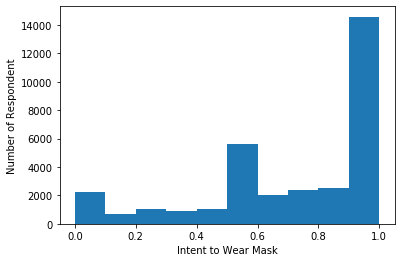

In [8]:
logisticregr = LogisticRegression()
plt.hist(survey['coronavirusIntent_Mask'])
plt.xlabel('Intent to Wear Mask')
plt.ylabel('Number of Respondent')

[4.56996223e-02 3.91773649e-14]
0.17318681510282208


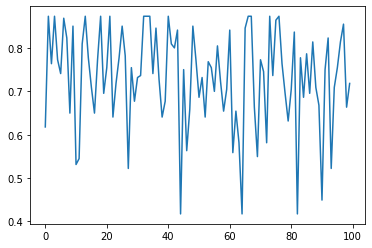

In [9]:
regr.fit(survey[['coronavirusConcern', 'HouseIncome']], survey['coronavirusIntent_Mask'])
print(regr.coef_)
print(regr.score(survey[['coronavirusConcern', 'HouseIncome']], survey['coronavirusIntent_Mask']))
x = plt.plot(regr.predict(survey[['coronavirusConcern', 'HouseIncome']][:100]))
#no relation between income/socioeconomic status and intent to wear masks
display(x)

In [10]:
#number of symptoms instead of actual symtoms
survey['coronavirusSymptoms'] = survey['coronavirusSymptoms'].str.count(",")
survey

,id,Age,coronavirusConcern,coronavirusEmployment,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusLocalCommunity,coronavirusSupportSystem,coronavirusSymptoms,ratioOfAdultHospitalization,coronavirusWhenShouldReopen,education,ethnicity,gender,hasCoronavirusBelief,politicalBelief,politicalParty,religion,religiosity,trumpApproval,zipcodePrefix,startTime,coronaSimilarFlu,coronaOnlyElderly,youngInvulnerable,elderlyMoreRisk,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,Location,HouseIncome
0,000279c1666d8f838cbf9573b25e943d,29,4.4,was-full,0.42,61.0,43.0,59.0,0.0,no-one,0,thirty-percent,1-yr,some-college,black,male,0.5,6.0,5.9,catholic,6.5,5.9,779.0,2020-05-28T22:44:34Z,False,False,False,True,False,False,False,False,True,False,False,True,Texas,68703.0
1,0002cc474056e14b010044a8547061a6,26,10.0,now-full,0.50,100.0,100.0,83.0,100.0,"fam-friend, local-gov, state-gov, fedgov",0,thirty-percent,few-days,college,hispanic-latino,male,1.8,7.7,10.0,catholic,4.9,7.2,274.0,2020-04-29T18:43:26Z,False,False,False,False,False,False,False,False,True,True,False,False,NorthCarolina,120000.0
2,00078a37abcdaa096a7572a406844d93,26,7.6,now-jobless,0.74,72.0,85.0,72.0,1.0,no-one,1,three-in-ten,1-mo,college,hispanic-latino,male,7.5,7.3,7.2,catholic,7.4,8.7,750.0,2020-06-10T01:24:05Z,False,False,False,False,True,False,False,True,False,True,False,False,Texas,10000.0
3,0007b4a0940ec892c58c0d875a305462,24,10.0,now-full,1.00,100.0,100.0,100.0,1.0,fam-friend,0,one-in-1k,3-mo,postgrad,black,female,0.0,5.2,0.0,something-else,7.3,0.0,300.0,2020-05-25T18:24:24Z,True,False,False,True,True,False,False,True,False,False,True,True,Georgia,35000.0
4,0014fa29afed18b4c3533df6d3fe3893,42,7.8,"was-jobless, now-jobless",0.88,88.0,83.0,87.0,1.0,"fam-friend, religious",4,three-in-ten,immediate,some-college,white,female,3.6,8.7,9.2,mormon,9.7,6.1,913.0,2020-06-10T05:08:20Z,False,False,False,True,True,False,False,True,False,True,False,False,California,199999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,fff5fdd4c4a3c967c1b4d9ecdfbcc114,32,4.6,now-jobless,1.00,100.0,100.0,100.0,0.0,no-one,0,almost-all,1-mo,some-college,white,male,0.0,5.1,5.1,agnostic,0.0,5.0,624.0,2020-05-28T23:09:58Z,False,False,False,False,True,False,False,True,False,True,False,False,Illinois,68703.0
1169,fffc5b58fce5ece5e69c2ef855c18a75,19,3.6,"now-part, was-jobless",0.58,57.0,55.0,28.0,0.0,"fedgov, local-gov",2,three-in-ten,1-wk,college,black,female,2.0,3.4,0.0,nothing-in-particular,2.3,0.0,280.0,2020-06-10T05:48:35Z,False,False,True,True,False,False,False,False,True,False,True,False,NorthCarolina,68703.0
1170,fffdae0c624a65c3e62b4727c0c1d664,27,0.0,was-jobless,0.50,1.0,2.0,1.0,9.0,fam-friend,0,three-percent,yr-plus,highschool,white,female,0.0,5.1,9.6,catholic,9.9,9.7,675.0,2020-04-29T18:35:19Z,True,False,False,False,False,False,False,True,False,False,True,False,Kansas,5000.0
1171,fffefea0ebd334434f8b0ee97c283ef8,59,7.9,now-disabled,0.97,99.0,99.0,99.0,0.0,"religious, fam-friend, fedgov, local-community",0,almost-all,6-mo,highschool,black,female,0.1,5.6,0.0,something-else,10.0,0.0,294.0,2020-05-06T05:22:37Z,False,False,False,True,True,False,False,True,False,True,True,False,SouthCarolina,9000.0


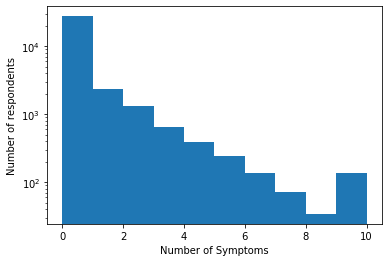

In [11]:
plt.hist(survey['coronavirusSymptoms'])
plt.xlabel("Number of Symptoms")
plt.ylabel("Number of respondents")
plt.yscale('log')

Text(0, 0.5, 'Household Income')

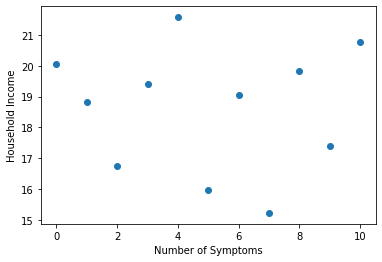

In [12]:
symptomsurvey = survey.groupby(by=['coronavirusSymptoms']).mean()
plt.scatter(symptomsurvey.index, np.log(symptomsurvey['HouseIncome']))
plt.xlabel('Number of Symptoms')
plt.ylabel('Household Income')
#no relation between the amount of symptoms and income

Text(0, 0.5, 'Intent to wear Mask')

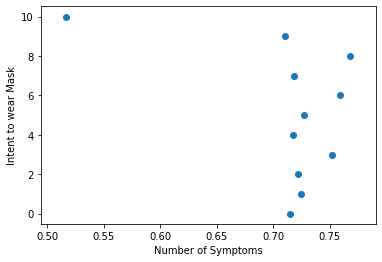

In [13]:
plt.scatter(symptomsurvey['coronavirusIntent_Mask'], symptomsurvey.index)
plt.xlabel('Number of Symptoms')
plt.ylabel('Intent to wear Mask')
#people that have more sympotms have lower probability of wearing mask

Text(0, 0.5, 'Intent to Stay Six Feet')

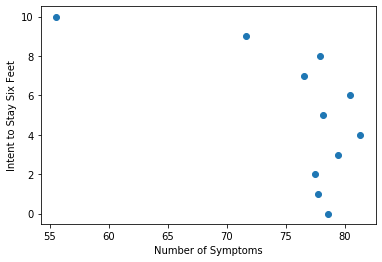

In [14]:
plt.scatter(symptomsurvey['coronavirusIntent_SixFeet'], symptomsurvey.index)
plt.xlabel('Number of Symptoms')
plt.ylabel('Intent to Stay Six Feet')

Text(0, 0.5, 'Average Concern for COVID')

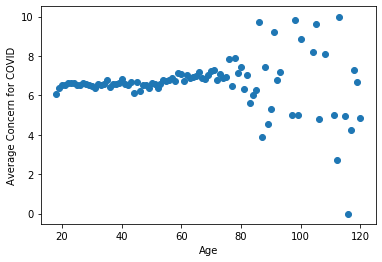

In [15]:
agesurvey = survey.groupby(by=['Age']).mean()
plt.scatter(agesurvey.index, agesurvey['coronavirusConcern'])
plt.xlabel('Age')
plt.ylabel('Average Concern for COVID')
#slight linear relationship between age and concern for COVID

/Users/arnavverma/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0, 0.5, 'Average Concern for COVID')

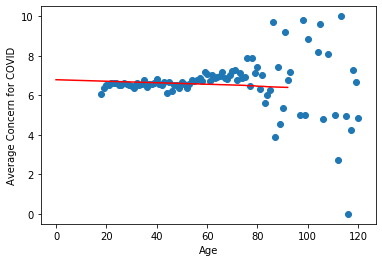

In [16]:
#fit linear regression to age relationship with average concern for covid
x = pd.DataFrame(index=agesurvey.index)
x.reset_index(inplace = True)
y = agesurvey[['coronavirusConcern']]
y.reset_index(inplace = True)
y.drop('Age', axis = 'columns', inplace = True)
regr.fit(x,y)
pred = regr.predict(x)
plt.plot(regr.predict(x), color = 'red')
plt.scatter(agesurvey.index, agesurvey['coronavirusConcern'])
plt.xlabel("Age")
plt.ylabel("Average Concern for COVID")
#the respondents that said that they were over 90 years old might be lying causing the regression line to have a
#negative slope, but no assumption was made about the invalidity of the data (overall the relation is constant)

In [17]:
#turn starttime into month (4, 5, 6)
survey['startTime'] = survey['startTime'].str.slice(6,7)
survey['startTime'] = survey['startTime'].astype(int)
survey

,id,Age,coronavirusConcern,coronavirusEmployment,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusLocalCommunity,coronavirusSupportSystem,coronavirusSymptoms,ratioOfAdultHospitalization,coronavirusWhenShouldReopen,education,ethnicity,gender,hasCoronavirusBelief,politicalBelief,politicalParty,religion,religiosity,trumpApproval,zipcodePrefix,startTime,coronaSimilarFlu,coronaOnlyElderly,youngInvulnerable,elderlyMoreRisk,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,Location,HouseIncome
0,000279c1666d8f838cbf9573b25e943d,29,4.4,was-full,0.42,61.0,43.0,59.0,0.0,no-one,0,thirty-percent,1-yr,some-college,black,male,0.5,6.0,5.9,catholic,6.5,5.9,779.0,5,False,False,False,True,False,False,False,False,True,False,False,True,Texas,68703.0
1,0002cc474056e14b010044a8547061a6,26,10.0,now-full,0.50,100.0,100.0,83.0,100.0,"fam-friend, local-gov, state-gov, fedgov",0,thirty-percent,few-days,college,hispanic-latino,male,1.8,7.7,10.0,catholic,4.9,7.2,274.0,4,False,False,False,False,False,False,False,False,True,True,False,False,NorthCarolina,120000.0
2,00078a37abcdaa096a7572a406844d93,26,7.6,now-jobless,0.74,72.0,85.0,72.0,1.0,no-one,1,three-in-ten,1-mo,college,hispanic-latino,male,7.5,7.3,7.2,catholic,7.4,8.7,750.0,6,False,False,False,False,True,False,False,True,False,True,False,False,Texas,10000.0
3,0007b4a0940ec892c58c0d875a305462,24,10.0,now-full,1.00,100.0,100.0,100.0,1.0,fam-friend,0,one-in-1k,3-mo,postgrad,black,female,0.0,5.2,0.0,something-else,7.3,0.0,300.0,5,True,False,False,True,True,False,False,True,False,False,True,True,Georgia,35000.0
4,0014fa29afed18b4c3533df6d3fe3893,42,7.8,"was-jobless, now-jobless",0.88,88.0,83.0,87.0,1.0,"fam-friend, religious",4,three-in-ten,immediate,some-college,white,female,3.6,8.7,9.2,mormon,9.7,6.1,913.0,6,False,False,False,True,True,False,False,True,False,True,False,False,California,199999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,fff5fdd4c4a3c967c1b4d9ecdfbcc114,32,4.6,now-jobless,1.00,100.0,100.0,100.0,0.0,no-one,0,almost-all,1-mo,some-college,white,male,0.0,5.1,5.1,agnostic,0.0,5.0,624.0,5,False,False,False,False,True,False,False,True,False,True,False,False,Illinois,68703.0
1169,fffc5b58fce5ece5e69c2ef855c18a75,19,3.6,"now-part, was-jobless",0.58,57.0,55.0,28.0,0.0,"fedgov, local-gov",2,three-in-ten,1-wk,college,black,female,2.0,3.4,0.0,nothing-in-particular,2.3,0.0,280.0,6,False,False,True,True,False,False,False,False,True,False,True,False,NorthCarolina,68703.0
1170,fffdae0c624a65c3e62b4727c0c1d664,27,0.0,was-jobless,0.50,1.0,2.0,1.0,9.0,fam-friend,0,three-percent,yr-plus,highschool,white,female,0.0,5.1,9.6,catholic,9.9,9.7,675.0,4,True,False,False,False,False,False,False,True,False,False,True,False,Kansas,5000.0
1171,fffefea0ebd334434f8b0ee97c283ef8,59,7.9,now-disabled,0.97,99.0,99.0,99.0,0.0,"religious, fam-friend, fedgov, local-community",0,almost-all,6-mo,highschool,black,female,0.1,5.6,0.0,something-else,10.0,0.0,294.0,5,False,False,False,True,True,False,False,True,False,True,True,False,SouthCarolina,9000.0


In [18]:
#group all survey entries by month and average out the responses for every column
datesurvey = survey.groupby(by=['startTime']).mean()
datesurvey

,Age,coronavirusConcern,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusLocalCommunity,coronavirusSymptoms,hasCoronavirusBelief,politicalBelief,politicalParty,religiosity,trumpApproval,zipcodePrefix,coronaSimilarFlu,coronaOnlyElderly,youngInvulnerable,elderlyMoreRisk,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,HouseIncome
startTime,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,32.695003,6.879216,0.553470,80.145132,79.089986,79.995023,43.521897,0.380052,2.049871,5.291141,5.106530,6.184591,4.430997,477.015728,0.207446,0.085009,0.119451,0.554051,0.458491,0.104718,0.179574,0.726259,0.182162,0.656779,0.268565,0.187139,3.722342e+08
5,34.222881,6.657211,0.747977,78.732280,74.488059,78.336672,42.573043,0.396148,1.848243,5.170616,4.953421,6.040285,4.244622,480.210478,0.196302,0.078428,0.103159,0.583128,0.484592,0.102234,0.166641,0.755008,0.165254,0.683975,0.249076,0.164253,5.028249e+08
6,33.862634,6.367255,0.744061,77.569778,71.517063,78.358053,35.338188,0.364892,1.788647,4.979365,4.800883,5.960716,3.697643,494.253884,0.197982,0.064799,0.104236,0.588567,0.486921,0.089762,0.156752,0.755477,0.167508,0.693799,0.239477,0.160536,4.909081e+08


/Users/arnavverma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/arnavverma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/arnavverma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Average Intent to wear Mask')

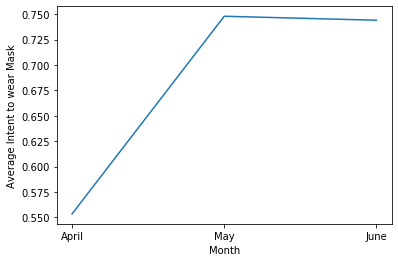

In [19]:
#visualize Intent to wear mask by month
plt.scatter(datesurvey.index, datesurvey['coronavirusIntent_Mask'])
datesurvey = datesurvey.rename(index={"4": "April", "5": "May", "6":"June"})
datesurvey['month'] = ['April','May','June']
plt.plot(datesurvey['month'], datesurvey['coronavirusIntent_Mask'])
plt.xlabel('Month')
plt.ylabel('Average Intent to wear Mask')


Text(0, 0.5, 'Average Intent on Staying Six Feet Apart')

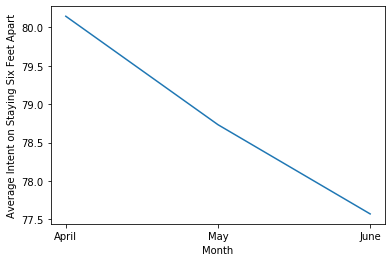

In [20]:
plt.plot(datesurvey['month'], datesurvey['coronavirusIntent_SixFeet'])
plt.xlabel('Month')
plt.ylabel('Average Intent on Staying Six Feet Apart')
#people seem to be less inclined to stay six feet away from each other over time (heavy negative correlation)

Text(0, 0.5, 'Average Intent of Staying at Home')

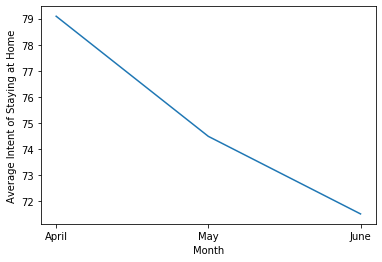

In [21]:
plt.plot(datesurvey['month'], datesurvey['coronavirusIntent_StayHome'])
plt.xlabel('Month')
plt.ylabel('Average Intent of Staying at Home')
#people seem to be less inclined to stay home over time (heavy negative correlation)

Text(0, 0.5, 'Average Concern for COVID')

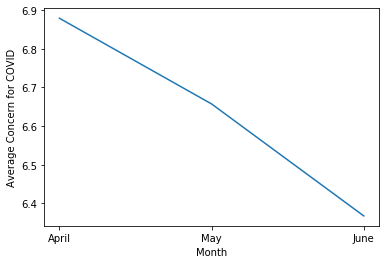

In [22]:
plt.plot(datesurvey['month'], datesurvey['coronavirusConcern'])
plt.xlabel('Month')
plt.ylabel('Average Concern for COVID')
#people are less concerned of coronavirus over time

In [23]:
"""SUMMARY (THIS SHOULD BE ON THE REPORT)

Government restrictions (USA) for the coronavirus such as stay at home orders and mask requirements were all in place by
April/May. We can see that people on average were all inclined to follow government policies for the most part (all
the visualized/analyzed data was from the United States). However, stay at home restrictions start becomind slightly
harder to enforce as seen by the negative slope in the intent of staying at home, staying siz feet away, and overall
average concern for coronavirus. Although the decline is minimal, it is evident that it exists from the visualizations.
Another important observation might be that people are willing to wear masks regardless, which might be because
of mandatory mask enforcement from outside places such as grocery/convenience stores etc. (Mention that the scale makes
the difference look bigger)"""

'SUMMARY (THIS SHOULD BE ON THE REPORT)\n\nGovernment restrictions (USA) for the coronavirus such as stay at home orders and mask requirements were all in place by\nApril/May. We can see that people on average were all inclined to follow government policies for the most part (all\nthe visualized/analyzed data was from the United States). However, stay at home restrictions start becomind slightly\nharder to enforce as seen by the negative slope in the intent of staying at home, staying siz feet away, and overall\naverage concern for coronavirus. Although the decline is minimal, it is evident that it exists from the visualizations.\nAnother important observation might be that people are willing to wear masks regardless, which might be because\nof mandatory mask enforcement from outside places such as grocery/convenience stores etc. (Mention that the scale makes\nthe difference look bigger)'